# Classifier Construction

In the classifier construction phase, we decide to focus on songs from 1990 to 2000. The dataset contains 256,805 songs, with title, genre, artist, year, and lyrics for each one. We assigned to the 1,083 Billboard Top songs the label 1, while the rest are labeled as 0. 

In [1]:
pip install joblib matplotlib seaborn scipy scikit-learn xgboost nltk

Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re



## Load the data 

In [34]:

os.chdir("/Users/ariannazottoli/Library/CloudStorage/OneDrive-UniversitàCommercialeLuigiBocconi/NLP/Project/Classifier")
data_90_99= pd.read_csv("total90_99.csv")
data_90_99

,title,tag,artist,year,lyrics,Label
0,Can I Live,rap,JAY-Z,1996,"Yeah, hah, yeah, Roc-A-Fella We invite you ...",0
1,Rockin and Rollin,rap,Cam'ron,1998,Ay yo you wonder who I are I guzzle up at the...,0
2,DEvils,rap,JAY-Z,1996,Dear God – I wonder,0
3,Its Hot Some Like It Hot,rap,JAY-Z,1999,"Yo, show closer, J-to-the-A-Y-Hovah Place s...",0
4,Its Like That,rap,JAY-Z,1998,"Yeah, uh-huh, watch this y'all Uhh, watch thi...",0
...,...,...,...,...,...,...
223175,Iris,rock,Goo Goo Dolls,1999,And I'd give up forever to touch you'Cause I k...,1
223176,Satisfy You,hip hop,Puff Daddy featuring R. Kelly,1999,All I want is somebody who's gonna love me for...,1
223177,Music of My Heart,pop,NSYNC and Gloria Estefan,1999,You'll never know what you've done for meWhat ...,1
223178,When You Believe,rb,Whitney Houston and Mariah Carey,1999,Many nights we've prayedWith no proof anyone c...,1


In [35]:
data_00_09= pd.read_csv("total00_09.csv")
data_00= data_00_09[data_00_09['year']==2000].reset_index(drop=True)
data_00

,title,tag,artist,year,lyrics,Label
0,98 Freestyle,rap,Big L,2000,"Yo, fuck all the glamours and glitz, I plan t...",0
1,Suck My Dick,rap,Lil' Kim,2000,Love me when I'm broke or when I'm filthy fuc...,0
2,Losin Weight,rap,Cam'ron,2000,Why I feel like I'm losing weight? Why I ain'...,0
3,Stan,rap,Eminem,2000,"My tea's gone cold, I'm wondering why I Got...",0
4,Kill You,rap,Eminem,2000,When I was just a little baby boy My momma ...,0
...,...,...,...,...,...,...
33620,Cowboy Take Me Away,country,Dixie Chicks,2000,"I said, ""I wanna touch the earthI wanna break ...",1
33621,I Don't Wanna,rb,Aaliyah,2000,"Ooh, yeah-yeah-yeahOh-oh, oh-yeah-yeahI don't ...",1
33622,Independent Women Part I,rb,Destiny's Child,2000,Lucy Liu With my girl Drew Cameron D. and Dest...,1
33623,Waiting for Tonight,pop,Jennifer Lopez,2000,"Oh, yeahLike a movie sceneIn the sweetest drea...",1


In [36]:
df= pd.concat([data_90_99, data_00], axis=0)
df

,title,tag,artist,year,lyrics,Label
0,Can I Live,rap,JAY-Z,1996,"Yeah, hah, yeah, Roc-A-Fella We invite you ...",0
1,Rockin and Rollin,rap,Cam'ron,1998,Ay yo you wonder who I are I guzzle up at the...,0
2,DEvils,rap,JAY-Z,1996,Dear God – I wonder,0
3,Its Hot Some Like It Hot,rap,JAY-Z,1999,"Yo, show closer, J-to-the-A-Y-Hovah Place s...",0
4,Its Like That,rap,JAY-Z,1998,"Yeah, uh-huh, watch this y'all Uhh, watch thi...",0
...,...,...,...,...,...,...
33620,Cowboy Take Me Away,country,Dixie Chicks,2000,"I said, ""I wanna touch the earthI wanna break ...",1
33621,I Don't Wanna,rb,Aaliyah,2000,"Ooh, yeah-yeah-yeahOh-oh, oh-yeah-yeahI don't ...",1
33622,Independent Women Part I,rb,Destiny's Child,2000,Lucy Liu With my girl Drew Cameron D. and Dest...,1
33623,Waiting for Tonight,pop,Jennifer Lopez,2000,"Oh, yeahLike a movie sceneIn the sweetest drea...",1


## Labels

In [37]:
labels= df['Label'].value_counts()/len(df)
labels 

Label
0    0.995783
1    0.004217
Name: count, dtype: float64

We have very imbalanced classes.

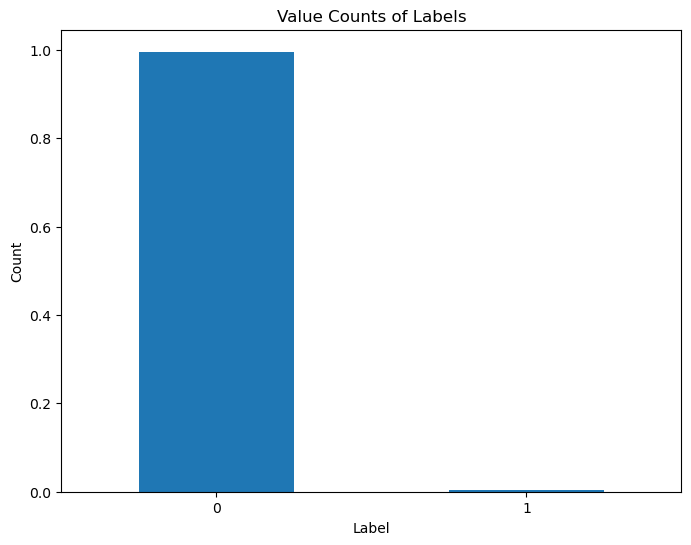

In [38]:
plt.figure(figsize=(8, 6))
labels.plot(kind='bar')
plt.title('Value Counts of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Tag

In [39]:
df['tag'].value_counts()

tag
pop               156588
rock               56529
rap                24925
country             8009
rb                  7557
misc                3042
hip hop               48
other                 15
dance                 12
blues                  7
soul                   7
reggae                 7
metal                  5
swing                  4
new wave               3
90s                    2
easy listening         2
post-grunge            2
funk                   1
drum and bass          1
oldies                 1
folk                   1
electronic             1
Name: count, dtype: int64

#### Standardize the less frequent genres into "other".


In [40]:

df.loc[~df['tag'].isin(['pop', 'rock', 'rap', 'rb', 'country', 'misc', 'hip hop', 'other']), 'tag']= 'other'
tags_total= df['tag'].value_counts()/ len(df)

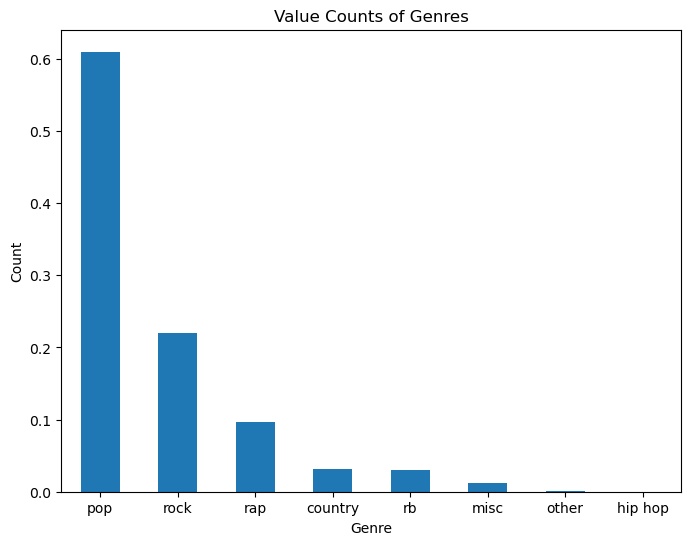

In [41]:
plt.figure(figsize=(8, 6))
tags_total.plot(kind='bar')
plt.title('Value Counts of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Handle class imbalance with undersampling

Handling class imbalance is an important step before building the classifier, because the dataset has a disproportionate number of instances for the two classes. If not handled properly, models may become biased towards the majority class (non-top songs, with label 0) and may have poor performance in predicting the minority class (top songs, with label 1).


## Stratified sampling

The following function performs stratified sampling by label and genre. It ensures that the resulting dataset maintains the distribution of tags within the majority class (non-top songs). 
We reduce the number of non-top songs to about 10,000 and keep all the top songs. 

In [31]:

def stratified_sampling(df, label_col='Label', tag_col='tag', total_n_samples=10000):
    
    tags = df[tag_col].unique()

    #Calculate the size of the majority class for each tag
    majority_class_sizes = df[df[label_col] == 0][tag_col].value_counts()
    total_majority_class_size = majority_class_sizes.sum()

    #Determine the number of samples per tag based on their proportion in the majority class
    tag_sample_sizes = (majority_class_sizes / total_majority_class_size * total_n_samples).astype(int)
    
    sampled_data = []

    for tag in tags:
        tag_df = df[df[tag_col] == tag]  

        #Split the tag dataframe into majority and minority classes
        df_majority = tag_df[tag_df[label_col] == 0]
        df_minority = tag_df[tag_df[label_col] == 1]

        #Determine the number of samples to draw for the current tag
        n_samples_tag = tag_sample_sizes.get(tag, 0)
        
        #Downsample the majority class
        df_majority_downsampled = resample(df_majority,
                                           replace=False,
                                           n_samples=min(len(df_majority), n_samples_tag),
                                           random_state=42)

        
        downsampled_tag = pd.concat([df_majority_downsampled, df_minority])
        sampled_data.append(downsampled_tag)

    df_downsampled = pd.concat(sampled_data)

    return df_downsampled


df_downsampled = stratified_sampling(df, label_col='Label', tag_col='tag', total_n_samples=10000)


print(df_downsampled['Label'].value_counts())
print(df_downsampled['tag'].value_counts())



Label
0    9997
1    1083
Name: count, dtype: int64
tag
pop        6423
rock       2403
rap        1063
rb          570
country     348
misc        118
other       107
hip hop      48
Name: count, dtype: int64


In [10]:
df_downsampled[df_downsampled['Label']==0]['tag'].value_counts()

tag
pop        6111
rock       2202
rap         971
country     311
rb          284
misc        118
Name: count, dtype: int64

# Data Exploration

Now we consider the extracted subsample to which we have added the sentiment scores for each song. Check the "sentiment_analysis.ipynb" notebook to see how the sentiment scores were calculated.


In [42]:
df_downsampled= pd.read_csv("df_downsampled_sent_10000.csv")
df_downsampled

,Unnamed: 0,title,tag,artist,year,lyrics,Label,text,negative,neutral,positive
0,0,Killagram,rap,Esham,1996,Its the Mr Unholy sinster Man I murdered you...,0,Its the Mr Unholy sinster Man I murdered your ...,0.8366,0.1525,0.0109
1,1,Riding and Surviving,rap,Prime Minister,2000,Im kickin this for my Lord and Savior Jesus C...,0,Im kickin this for my Lord and Savior Jesus Ch...,0.1080,0.7115,0.1805
2,2,Win the G,rap,O.C.,1997,OC ft Bumpy Knuckles Win the G Yo OC are...,0,OC ft Bumpy Knuckles Win the G Yo OC are you r...,0.4090,0.5169,0.0740
3,3,Old to the New,rap,Nice & Smooth,1994,Artist Nice Smooth Album Jewel of the Nile S...,0,Artist Nice Smooth Album Jewel of the Nile Son...,0.0734,0.5730,0.3536
4,4,Well Never Stop,rap,Rakim,1999,We love to flirt To chase the skirts Get to k...,0,We love to flirt To chase the skirts Get to k...,0.3223,0.5714,0.1063
...,...,...,...,...,...,...,...,...,...,...,...
11075,11075,Satisfy You,hip hop,Puff Daddy featuring R. Kelly,1999,All I want is somebody whos gonna love me for ...,1,All I want is somebody whos gonna love me for ...,0.1174,0.5791,0.3035
11076,11076,Big Pimpin',hip hop,Jay-Z featuring UGK,2000,Uh uh uh uhIts big pimpin baby Its big pimpin ...,1,Uh uh uh uhIts big pimpin baby Its big pimpin ...,0.4372,0.4580,0.1048
11077,11077,Forgot About Dre,hip hop,Dr. Dre featuring Eminem,2000,Yall know me still the same OGBut I been lowke...,1,Yall know me still the same OGBut I been lowke...,0.6672,0.2988,0.0341
11078,11078,The Next Episode,hip hop,Dr. Dre featuring Snoop Dogg,2000,LadadadadahIts the motherfuckin DOdoubleG Lada...,1,LadadadadahIts the motherfuckin DOdoubleG Lada...,0.5132,0.4103,0.0765


### Labels

In [23]:
labels= df_downsampled['Label'].value_counts()/len(df_downsampled)
labels 

Label
0    0.902256
1    0.097744
Name: count, dtype: float64

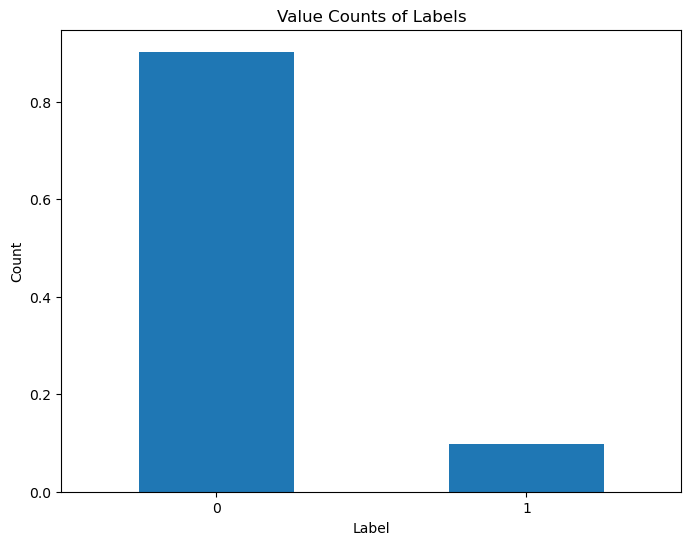

In [24]:
plt.figure(figsize=(8, 6))
labels.plot(kind='bar')
plt.title('Value Counts of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The classes are still imbalanced, but not as much as in the entire dataset.

### Tags

In [25]:
tags_total= df_downsampled['tag'].value_counts()/ len(df_downsampled)

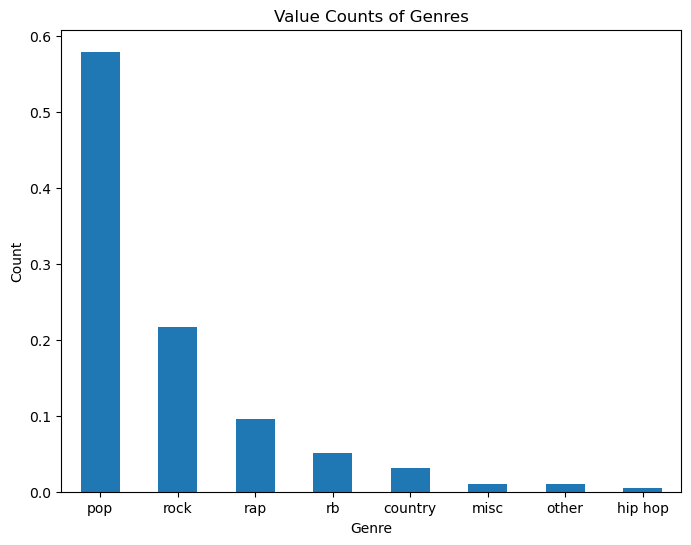

In [26]:
plt.figure(figsize=(8, 6))
tags_total.plot(kind='bar')
plt.title('Value Counts of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

As expected given the period, the three most popular genres in our dataset are pop, rock, and rap, followed by R&B and country.

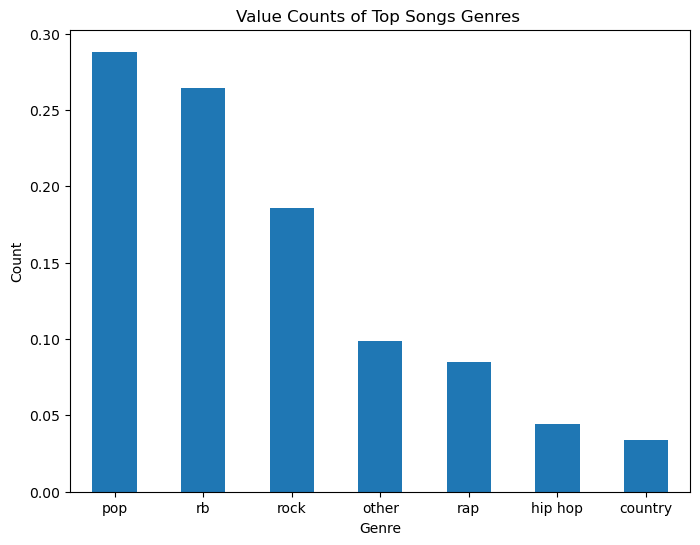

In [27]:
df_label1= df_downsampled[df_downsampled['Label']==1]
tags_1= df_label1['tag'].value_counts() /len(df_label1)

plt.figure(figsize=(8, 6))
tags_1.plot(kind='bar')
plt.title('Value Counts of Top Songs Genres ')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

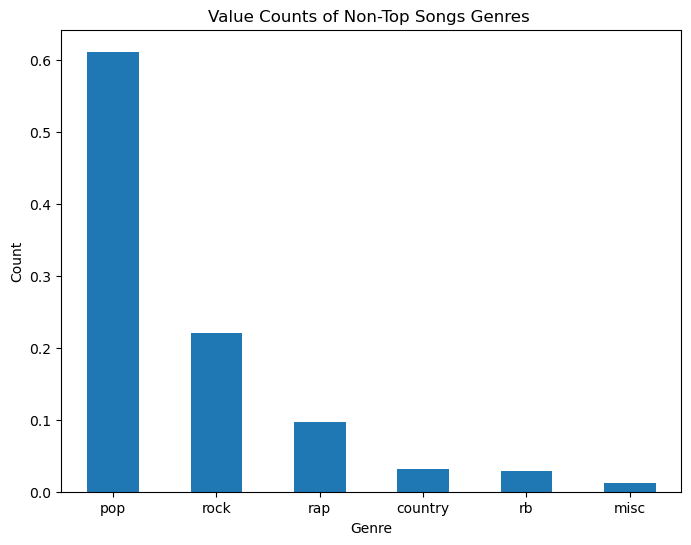

In [28]:
df_label0= df_downsampled[df_downsampled['Label']==0]
tags_0= df_label0['tag'].value_counts()/len(df_label0)

plt.figure(figsize=(8, 6))
tags_0.plot(kind='bar')
plt.title('Value Counts of Non-Top Songs Genres ')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1

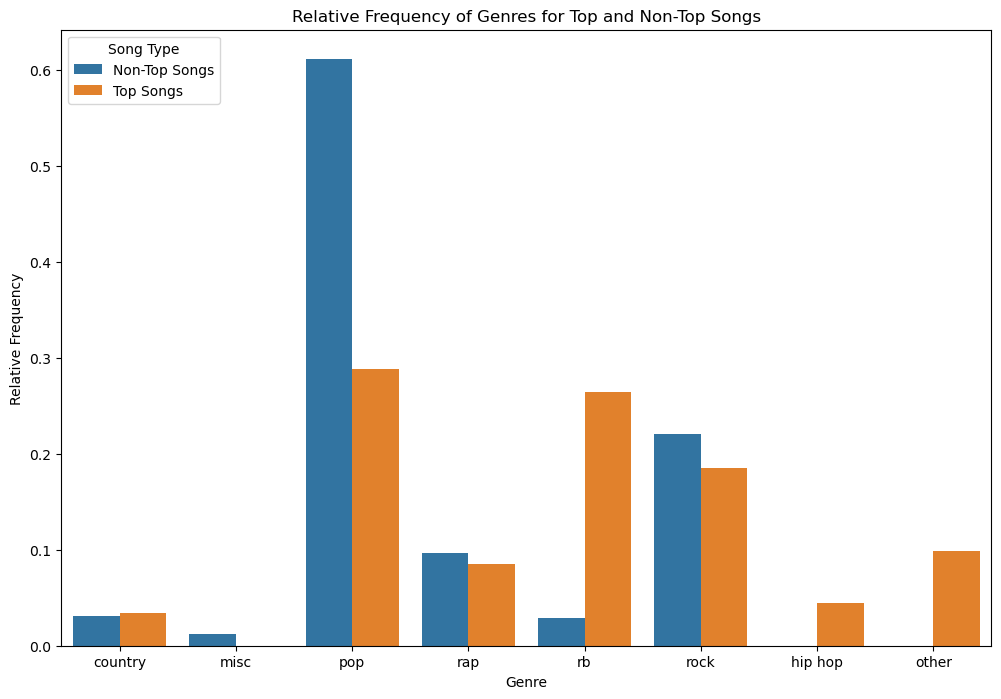

In [47]:

genre_counts = df_downsampled.groupby(['Label', 'tag']).size().reset_index(name='count')
genre_totals = genre_counts.groupby('Label')['count'].sum().reset_index(name='total')

genre_relative_freq = pd.merge(genre_counts, genre_totals, on='Label')
genre_relative_freq['relative_frequency'] = genre_relative_freq['count'] / genre_relative_freq['total']


genre_relative_freq['Label'] = genre_relative_freq['Label'].map({1: 'Top Songs', 0: 'Non-Top Songs'})


plt.figure(figsize=(12, 8))
sns.barplot(x='tag', y='relative_frequency', hue='Label', data=genre_relative_freq)
plt.title('Relative Frequency of Genres for Top and Non-Top Songs')
plt.xlabel('Genre')
plt.ylabel('Relative Frequency')
plt.legend(title='Song Type')
plt.show()



Regarding the top songs, the most popular genres are pop, R&B, and rock, while for the non-top songs, they are pop, rock, and rap.

### Artists

#### Most frent artists in top songs

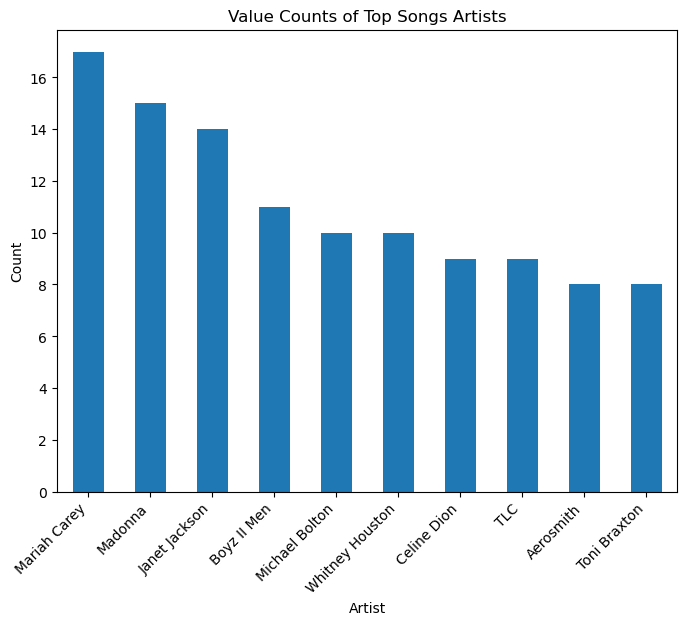

In [30]:
df_label_1 = df_downsampled[df_downsampled['Label'] == 1]
artists_counts= df_label_1['artist'].value_counts()


plt.figure(figsize=(8, 6))
artists_counts.head(10).plot(kind='bar')
plt.title('Value Counts of Top Songs Artists')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Consistent with what we found earlier, the top 10 Billboard artists from the 1990s to the 2000s are mainly from rock, pop, and R&B genres. 

### Average Sentiment Scores

   Label   neutral  positive  negative
0      0  0.442689  0.233328  0.323984
1      1  0.449844  0.337137  0.213020


/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1

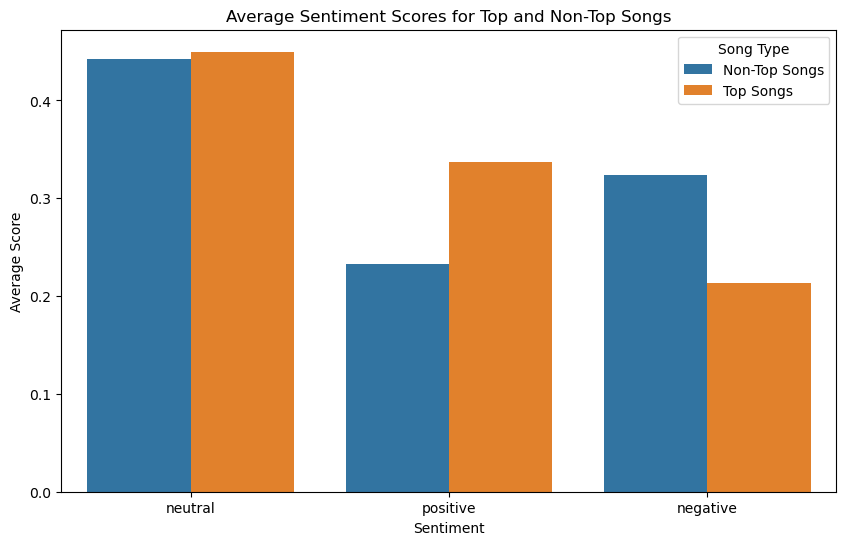

In [ ]:

average_scores = df_downsampled.groupby('Label')[['neutral', 'positive', 'negative']].mean().reset_index()
print(average_scores)

average_scores['Label'] = average_scores['Label'].map({1: 'Top Songs', 0: 'Non-Top Songs'})
average_scores_melted = average_scores.melt(id_vars='Label', var_name='sentiment', value_name='average_score')

plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='average_score', hue='Label', data=average_scores_melted)
plt.title('Average Sentiment Scores for Top and Non-Top Songs')
plt.xlabel('Sentiment')
plt.ylabel('Average Score')
plt.legend(title='Song Type')
plt.show()


Comparing the average sentiment scores of top and non-top songs, we can see that top songs have higher average positive and neutral scores compared to non-top songs.The average negative score is higher for non-top songs compared to top songs.

The differences between the two groups (top and non-top songs) in terms of genres and average sentiment scores might suggest that they could be relevant factors in predicting whether a song can be classified as top or not. However, these results are exploratory and require further analysis and modeling.

## Split the data

In [ ]:
df_downsampled= pd.read_csv("df_downsampled_sent_10000.csv")
df_downsampled

We split the data into train and test sets. We will use the train set to train the model and the test set to evaluate the model's performance.
The response variable are the labels 0 and 1.

In [13]:
X = df_downsampled[['title', 'tag', 'artist', 'year', 'lyrics', 'negative', 'positive']]
y = df_downsampled['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Text data vector representations 

To represent text data, we transformed the lyrics trying two different vector representations: TF-IDF and Sentence Transformers. 

## TF-IDF

### Pre-processing

Before applying the Tf-idf Vectorizer, we pre-process the song lyrics with: 
- lowercasing
- non-word characters removal
- tokenization
- stopwords removal
- lemmatization

In [6]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)



In [10]:
lyrics_train= X_train['lyrics'].apply(preprocess_text)
lyrics_test= X_test['lyrics'].apply(preprocess_text)

In [11]:
X_train['lyrics_cleaned']= lyrics_train
X_test['lyrics_cleaned']= lyrics_test

In [ ]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')
y_train.to_csv('y_train.csv')

### TF-IDF

The Tf-idf Vectorizer generates both unigrams and bigrams, analyzing the text at the word level. It ignores terms that have a document frequency strictly lower than 1% and strictly higher than 80% across the corpus.

Firstly, we train the representation model on the pre-processed training data, which are trasformed into TF-IDF matrix. Then, we trasform the pre-processed song lyrics in the test set into TF-IDF vectors using the TF-IDF vectorizer previously fitted on the training data. 

In [12]:

vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             analyzer="word",
                             min_df= 0.01,
                             max_df= 0.80,
                             sublinear_tf= True)

train_lyrics_tfidf = vectorizer.fit_transform(X_train['lyrics_cleaned'])

print(train_lyrics_tfidf.shape)


(8864, 1195)


In [ ]:


joblib.dump(vectorizer, 'tfidf_vectorizer_10000.joblib')

['tfidf_vectorizer_10000.joblib']

In [13]:

test_lyrics_tfidf = vectorizer.transform(X_test['lyrics_cleaned'])

We apply one-hot encoding to the song genre converting the categorical labels into binary vectors. 

In [14]:
ohe = OneHotEncoder()
train_genres_encoded = ohe.fit_transform(X_train[['tag']])
test_genres_encoded = ohe.transform(X_test[['tag']])

We obtain the matrix  of predictors both for train and test combining the TF-IDF matrix of lyrics, the encoded genre features and negative and positive sentiment scores. We exclude the neutral score to avoid collinearity.

In [15]:
X_train_combined_tfidf = hstack([train_lyrics_tfidf, train_genres_encoded, X_train[['negative', 'positive']]])
X_test_combined_tfidf = hstack([test_lyrics_tfidf, test_genres_encoded, X_test[['negative', 'positive']]])

In [ ]:
data= pd.DataFrame(X_test_combined_tfidf.toarray())
data.to_csv('X_test_combined_tfidf_10000.csv', index=False)

In [ ]:
data= pd.DataFrame(X_train_combined_tfidf.toarray())
data.to_csv('X_train_combined_tfidf_10000.csv', index=False)

## Sentence Transformer

As second attempt of text data vector representation, we use the Sentence Transformer algorithm based on Transformers, which are neural network architectures designed to generate high-quality sentence embeddings. We use the model 'all-MiniLM-L6-v2', a distilled version of larger models like BERT, fine-tuned on various datasets to generate 384-dimensional vectors.

In [ ]:
pip install sentence-transformers

In [15]:
from sentence_transformers import SentenceTransformer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = model.encode(X_train['lyrics'].tolist(), show_progress_bar=True)
test_embeddings = model.encode(X_test['lyrics'].tolist(), show_progress_bar=True)

/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ariannazottoli/anaconda3/envs/Python4DataScience/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


As before, we apply one-hot encoding to the song genre converting the categorical labels into binary vectors.

We obtain a second matrix of predictors both for train and test combining the lyrics embeddings, the encoded genre features and negative and positive sentiment scores. We exclude the neutral score to avoid collinearity.

In [ ]:
ohe = OneHotEncoder()
train_genres_encoded = ohe.fit_transform(X_train[['tag']])
test_genres_encoded = ohe.transform(X_test[['tag']])

In [ ]:
X_train_combined_st = hstack([train_embeddings, train_genres_encoded, X_train[['negative', 'positive']]])
X_test_combined_st = hstack([test_embeddings, test_genres_encoded, X_test[['negative', 'positive']]])

For each classifier tested (Logistic Regression, Random Forest and XGBoost), we use the two matrices of predictors previously built.
We train each model on the training set and compare the models' performance using precision, recall, F1-score, accuracy, and the confusion matrix on the test set. 
The best hyperparameters are selected using the 5-Fold Cross Validation.

In each model, we add higher weights to top songs, to improve perfomance on them given the class imbalance.


# 1. Baseline: Logistic Regression

## TF-IDF

In [ ]:


logistic_balanced = LogisticRegression(class_weight="balanced",solver='lbfgs', max_iter=1000, n_jobs=-1)

#We perform the 5-Fold Cross Validation to choose the L2 regularization parameter, using the 
#F1-score as metric
param_grid = {
    'C': [10, 5, 1, 0.01]
}

grid_search = GridSearchCV(logistic_balanced, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_combined_tfidf, y_train)
print("Best F1 score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)


best_model = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best F1 score: 0.6803886098249359
Best parameters: {'C': 1}


              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1999
           1       0.37      0.71      0.49       217

    accuracy                           0.85      2216
   macro avg       0.67      0.79      0.70      2216
weighted avg       0.91      0.85      0.87      2216

[[1735  264]
 [  63  154]]


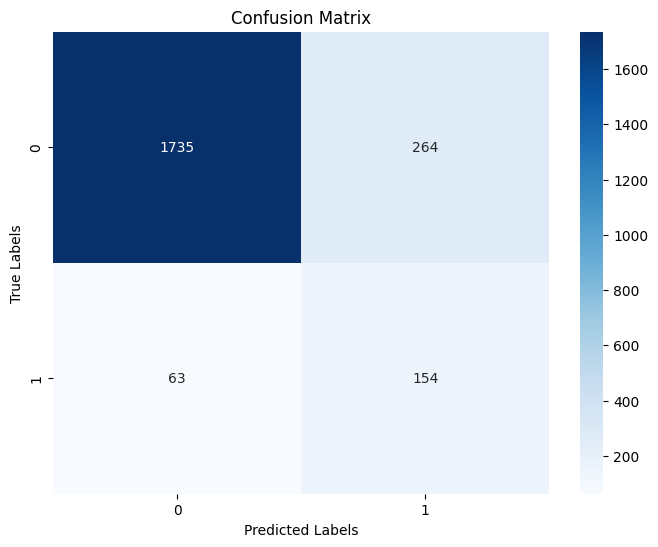

In [ ]:
best_model.fit(X_train_combined_tfidf, y_train)
predictions = best_model.predict(X_test_combined_tfidf)

classification_report1= classification_report(y_test, predictions, output_dict= True)
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions, labels= best_model.classes_)
print(cm)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_model.classes_)
ax.yaxis.set_ticklabels(best_model.classes_)
plt.show()

## Sentence Trasformer

In [ ]:
train_embeddings.shape

(8864, 384)

In [ ]:
logistic_balanced = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, n_jobs=-1)

#We perform the 5-Fold Cross Validation to choose the L2 regularization parameter, using the 
#F1-score as metric

param_grid = {
    'C': [10, 5, 1, 0.01]
}

grid_search = GridSearchCV(logistic_balanced, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_combined_st, y_train)
print("Best F1 score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)


best_model_transformer = grid_search.best_estimator_

Best F1 score: 0.665719878127653
Best parameters: {'C': 1}


              precision    recall  f1-score   support

           0       0.97      0.82      0.88      1999
           1       0.30      0.73      0.42       217

    accuracy                           0.81      2216
   macro avg       0.63      0.77      0.65      2216
weighted avg       0.90      0.81      0.84      2216

[[1630  369]
 [  59  158]]


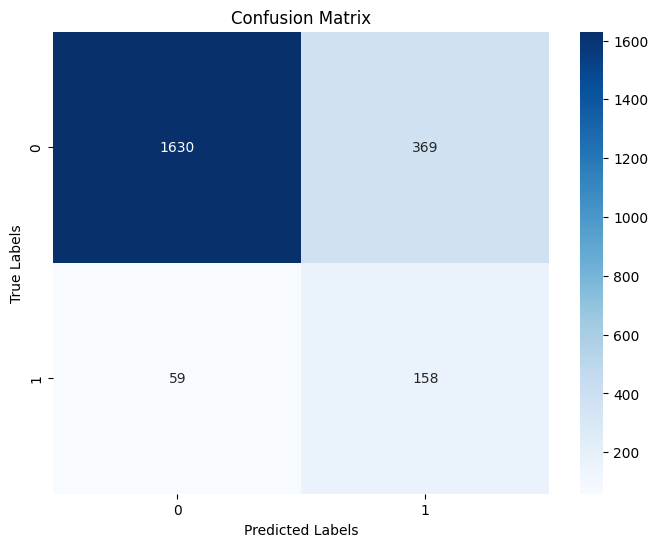

In [ ]:
best_model_transformer.fit(X_train_combined_st, y_train)
predictions = best_model_transformer.predict(X_test_combined_st)

classification_report2= classification_report(y_test, predictions, output_dict=True)
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions, labels= best_model_transformer.classes_)
print(cm)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_model.classes_)
ax.yaxis.set_ticklabels(best_model.classes_)
plt.show()

# 2. Random Forest

## TF-IDF

In [16]:
X_train_combined_tfidf.shape

(8864, 1205)

Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best F1 score:  0.6982280480327903
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1999
           1       0.48      0.61      0.54       217

    accuracy                           0.90      2216
   macro avg       0.72      0.77      0.74      2216
weighted avg       0.91      0.90      0.90      2216

[[1854  145]
 [  84  133]]


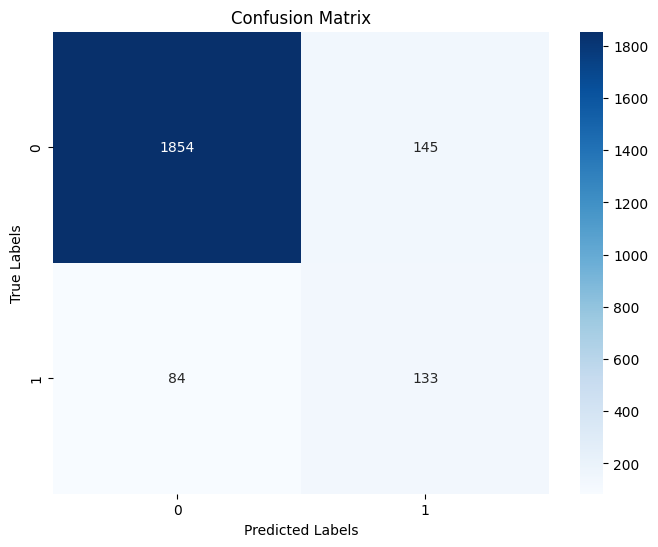

In [17]:
#We perform the 5-Fold Cross Validation to choose the best hyperparameters for the Random Forest Classifier, 
#using the F1-score as metric

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=80, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train_combined_tfidf, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


best_rf = grid_search.best_estimator_
best_rf.fit(X_train_combined_tfidf, y_train)

y_pred = best_rf.predict(X_test_combined_tfidf)


classification_report3= classification_report(y_test, y_pred, output_dict= True)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
print(cm)


fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_rf.classes_)
ax.yaxis.set_ticklabels(best_rf.classes_)
plt.show()


## Sentence Trasformer

Best parameters found:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 score:  0.6734603940815522
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1999
           1       0.41      0.48      0.44       217

    accuracy                           0.88      2216
   macro avg       0.68      0.70      0.69      2216
weighted avg       0.89      0.88      0.89      2216

[[1847  152]
 [ 112  105]]


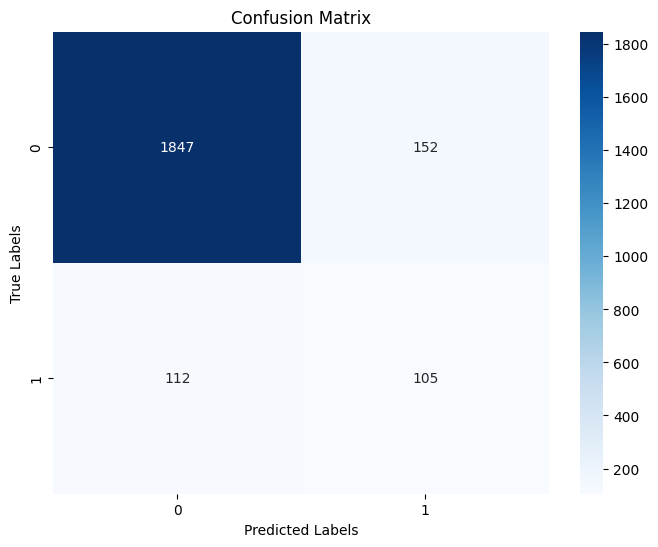

In [ ]:
#We perform the 5-Fold Cross Validation to choose the best hyperparameters for the Random Forest Classifier, 
#using the F1-score as metric

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=80, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='f1_macro')

grid_search.fit(X_train_combined_st, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


best_rf_st= grid_search.best_estimator_
best_rf_st.fit(X_train_combined_st, y_train)
y_pred = best_rf.predict(X_test_combined_st)
classification_report4= classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=best_rf_st.classes_)
print(cm)


fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_rf_st.classes_)
ax.yaxis.set_ticklabels(best_rf_st.classes_)
plt.show()

# 4. XGBoost

## TF-IDF

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1999
           1       0.51      0.51      0.51       217

    accuracy                           0.90      2216
   macro avg       0.73      0.73      0.73      2216
weighted avg       0.90      0.90      0.90      2216

[[1894  105]
 [ 106  111]]


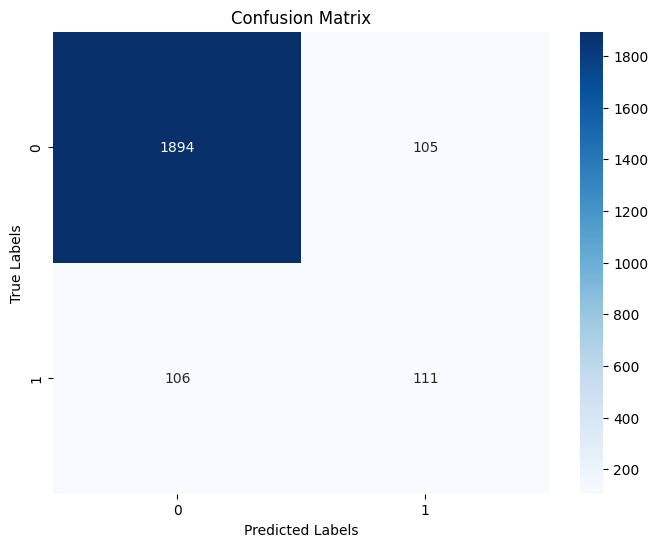

In [ ]:
class_counts = np.bincount(y_train)
weights = class_counts[0] / class_counts[1]


fixed_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 1,
    'random_state': 80,
    'scale_pos_weight': weights
}


xgb = XGBClassifier(**fixed_params)
xgb.fit(X_train_combined_tfidf, y_train)
y_pred = xgb.predict(X_test_combined_tfidf)


classification_report5= classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
print(cm)



fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(xgb.classes_)
ax.yaxis.set_ticklabels(xgb.classes_)
plt.show()



## Sentence Trasformer

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1999
           1       0.61      0.40      0.48       217

    accuracy                           0.92      2216
   macro avg       0.77      0.68      0.72      2216
weighted avg       0.90      0.92      0.91      2216

[[1944   55]
 [ 131   86]]


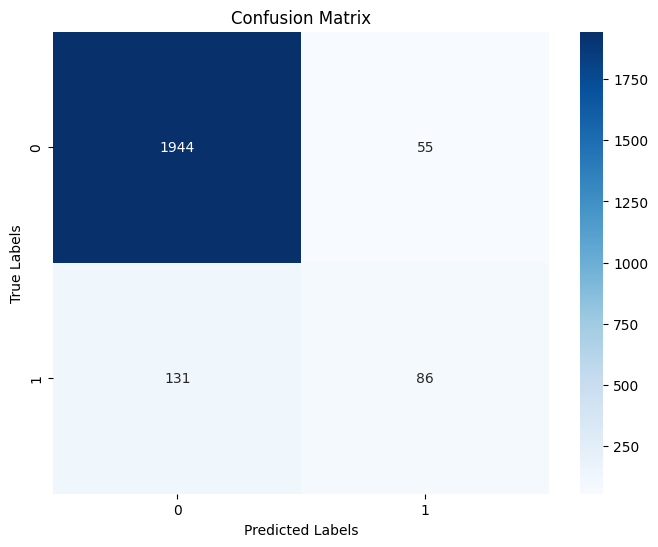

In [ ]:
class_counts = np.bincount(y_train)
weights = class_counts[0] / class_counts[1]


fixed_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 1,
    'random_state': 80,
    'scale_pos_weight': weights
}


xgb = XGBClassifier(**fixed_params)
xgb.fit(X_train_combined_st, y_train)
y_pred = xgb.predict(X_test_combined_st)


classification_report6= classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
print(cm)


fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(xgb.classes_)
ax.yaxis.set_ticklabels(xgb.classes_)
plt.show()

# SUMMARY

In the following table, we sum up the models' performance in terms of average F1-score, precision, recall and accuracy on the test set. We consider the macro average and not the weighted average to ensure we are not ignoring the models' performance on the minority class, given the imbalanced nature of the dataset.

In [ ]:
list_dicts= [classification_report1['macro avg'], classification_report2['macro avg'], classification_report3['macro avg'],
             classification_report4['macro avg'], classification_report5['macro avg'], classification_report6['macro avg']]
row_names= ["Logistic + TF-IDF", "Logistic + SentenceTransformer", "RF + TF-IDF", "RF + SentenceTransformer",
            "XGBoost + TF-IDF", "XGBoost + SentenceTransformer"]
summary= pd.DataFrame(list_dicts, index= row_names)
summary

,precision,recall,f1-score,support
Logistic + TF-IDF,0.666691,0.788806,0.699459,2216
Logistic + SentenceTransformer,0.632439,0.771759,0.654340,2216
RF + TF-IDF,0.717537,0.770183,0.739604,2216
RF + SentenceTransformer,0.675694,0.703916,0.688169,2216
XGBoost + TF-IDF,0.730444,0.729497,0.729969,2216
XGBoost + SentenceTransformer,0.773398,0.684400,0.717396,2216


The models show similar performances.
We focus particularly on the average F1-score because it balances precision and recall, providing a better measure of the classifier’s performance in the presence of class imbalances. The best classification model is Random Forest, which uses the genre, sentiment scores, and TF-IDF vector representation of the lyrics as predictors. 

In [18]:
joblib.dump(best_rf, "random_forest_textgenresent.joblib")

['random_forest_textgenresent.joblib']

Now we evaluate whether dimensionality reduction through Truncated Singular Value Decomposition and the inclusion of genre and sentiment scores as predictors improve the models' performance or not.

## Dimensionality reduction

In [19]:

pipe = Pipeline([
    ('reduction', 'passthrough'),
    ('classifier', best_rf)
])

param_grid = [
    {
        'reduction': [TruncatedSVD()],
        'reduction__n_components': [500, 400, 300, 200, 100, 50, 25]
    },
]

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    cv=5,
                    scoring='f1_macro',
                    n_jobs=-1,
                   )
grid.fit(X_train_combined_tfidf, y_train)
print(grid.best_score_, grid.best_params_['reduction'])

reductor = grid.best_params_['reduction'].fit(X_train_combined_tfidf, y_train)
X_train_sel = reductor.transform(X_train_combined_tfidf)
X_test_sel = reductor.transform(X_test_combined_tfidf)

0.7185692975966773 TruncatedSVD(n_components=400)


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1999
           1       0.60      0.44      0.51       217

    accuracy                           0.92      2216
   macro avg       0.77      0.71      0.73      2216
weighted avg       0.91      0.92      0.91      2216

[[1936   63]
 [ 121   96]]


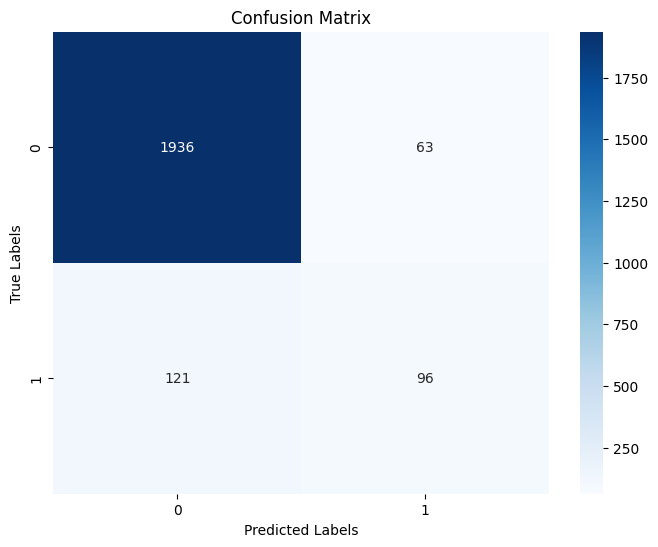

In [20]:
best_rf.fit(X_train_sel, y_train)
predictions = best_rf.predict(X_test_sel)

print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions, labels= best_rf.classes_)
print(cm)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_rf.classes_)
ax.yaxis.set_ticklabels(best_rf.classes_)
plt.show()

## RF without genres and sentiment

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best F1 score:  0.6481242611480793
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1999
           1       0.35      0.43      0.38       217

    accuracy                           0.87      2216
   macro avg       0.64      0.67      0.65      2216
weighted avg       0.88      0.87      0.87      2216

[[1825  174]
 [ 124   93]]


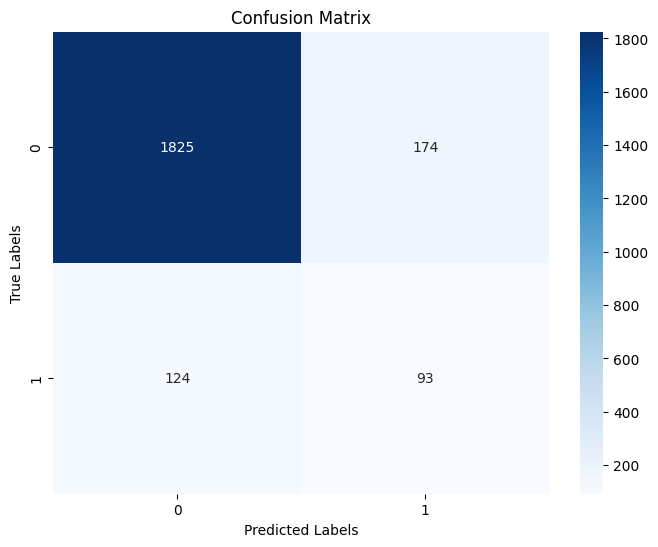

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=80, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(train_lyrics_tfidf, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


best_rf = grid_search.best_estimator_
best_rf.fit(train_lyrics_tfidf, y_train)
joblib.dump(best_rf, 'random_forest_model_text.joblib')
y_pred = best_rf.predict(test_lyrics_tfidf)



print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
print(cm)


fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_rf.classes_)
ax.yaxis.set_ticklabels(best_rf.classes_)
plt.show()


## RF without genres

In [ ]:
X_train_combined = hstack([train_lyrics_tfidf, X_train[['negative', 'positive']]])
X_test_combined = hstack([test_lyrics_tfidf, X_test[['negative', 'positive']]])

Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 score:  0.6487773994118061
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1999
           1       0.33      0.46      0.39       217

    accuracy                           0.86      2216
   macro avg       0.64      0.68      0.65      2216
weighted avg       0.88      0.86      0.87      2216

[[1798  201]
 [ 117  100]]


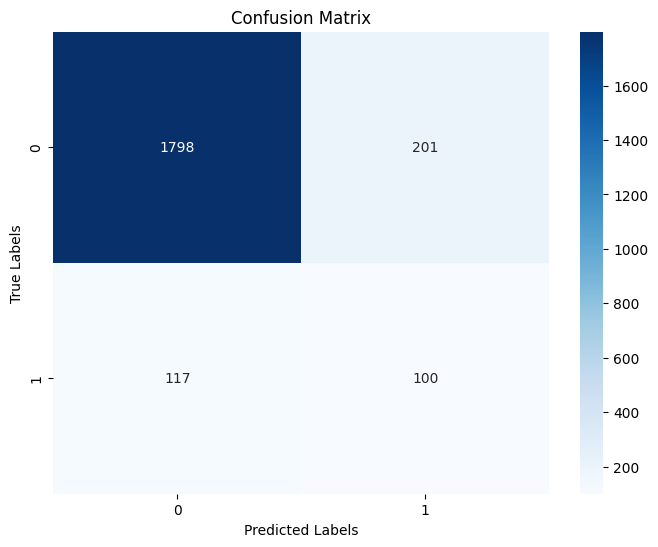

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=80, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train_combined, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


best_rf = grid_search.best_estimator_
best_rf.fit(X_train_combined, y_train)
joblib.dump(best_rf, 'random_forest_model_textsent.joblib')
y_pred = best_rf.predict(X_test_combined)



print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
print(cm)


fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_rf.classes_)
ax.yaxis.set_ticklabels(best_rf.classes_)
plt.show()

## RF without sentiment

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score:  0.7090383273303098
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1999
           1       0.46      0.57      0.51       217

    accuracy                           0.89      2216
   macro avg       0.71      0.75      0.73      2216
weighted avg       0.90      0.89      0.90      2216

[[1855  144]
 [  93  124]]


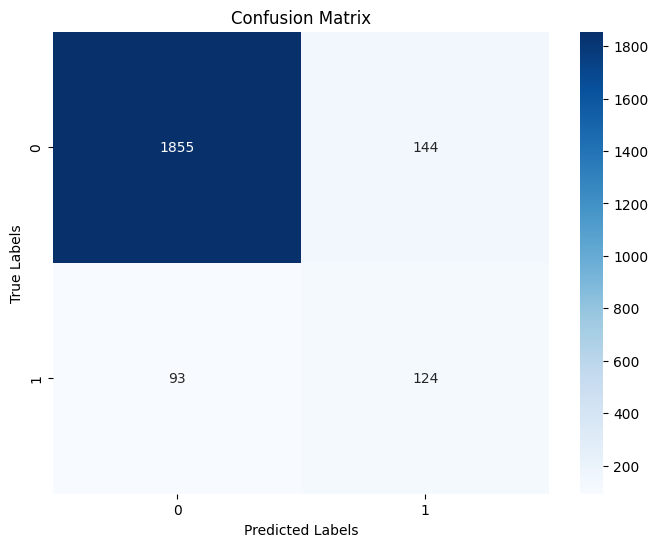

In [ ]:
X_train_combined = hstack([train_lyrics_tfidf, train_genres_encoded])
X_test_combined = hstack([test_lyrics_tfidf, test_genres_encoded])

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=80, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train_combined, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


best_rf = grid_search.best_estimator_
best_rf.fit(X_train_combined, y_train)
joblib.dump(best_rf, 'random_forest_model_textgenre.joblib')
y_pred = best_rf.predict(X_test_combined)



print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
print(cm)


fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(best_rf.classes_)
ax.yaxis.set_ticklabels(best_rf.classes_)
plt.show()

## Conclusions

These results reveal that the inclusion of the genres and sentiment improves predictions. Dimensionality reduction, instead, does not improve the model's perfomance.